In [1]:
import pandas as pd
from sqlalchemy import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [2]:
sqlite_path = "../data_collection/reddit_ed_0.6.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread":False},
)

In [3]:
from sqlalchemy import inspect
inspector = inspect(engine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print("table: %s" % table_name)
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column)

schema: main
table: filtered_200
Column: {'name': 'subreddit', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'selftext', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'author_fullname', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'title', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'score', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'link_flair_css_class', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'link_flair_text', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'author_flair_type', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'over_18', 'type': NUMERIC(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'author_flair_text', 'type': TEXT

In [5]:
query = f"select * from subreddit_submission_metadata"
df = pd.read_sql_query(text(query),con=engine.connect())
df.head()


,subreddit,selftext,author_fullname,title,score,link_flair_css_class,link_flair_text,author_flair_type,over_18,author_flair_text,subreddit_id,id,is_self,author,author_flair_css_class,permalink,url,created_utc
0,EatingDisorders,23 F. I just started treatment for an eating d...,None,I need moral support,1,,Seeking Support,None,None,None,t5_2qpcj,10poqxu,1,GullibleCup27,None,/r/EatingDisorders/comments/10poqxu/i_need_mor...,https://www.reddit.com/r/EatingDisorders/comme...,1675140001
1,EatingDisorders,I 26 f told the truth for the first time about...,None,Opening up about my ed,1,,Seeking Support,None,None,None,t5_2qpcj,10pnoxo,1,mistinthrowaway,None,/r/EatingDisorders/comments/10pnoxo/opening_up...,https://www.reddit.com/r/EatingDisorders/comme...,1675137504
2,EatingDisorders,[removed],None,My Long Battle With Binge Eating Coming To An End,1,one,Recovery Story,None,None,None,t5_2qpcj,10plv3v,1,LetMeTuckYouInHomie,None,/r/EatingDisorders/comments/10plv3v/my_long_ba...,https://www.reddit.com/r/EatingDisorders/comme...,1675132759
3,EatingDisorders,"Greetings,\n\nA research team from Carnegie Va...",None,[Mod Approved] Are you a man who has experienc...,1,None,None,None,None,None,t5_2qpcj,10pkd8e,1,Acceptable_Ad_3206,None,/r/EatingDisorders/comments/10pkd8e/mod_approv...,https://www.reddit.com/r/EatingDisorders/comme...,1675128549
4,EatingDisorders,Idk who to talk to about this so I resort to r...,None,Just ranting ig,1,None,None,None,None,None,t5_2qpcj,10pjinj,1,tomato_bean876,None,/r/EatingDisorders/comments/10pjinj/just_ranti...,https://www.reddit.com/r/EatingDisorders/comme...,1675126245


## Pre-processing

### Remove very short posts or posts are removed

<Axes: >

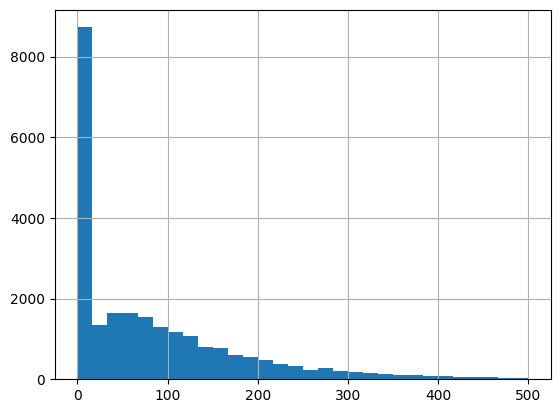

In [60]:
df["num_words"] = df["selftext"].apply(lambda x: len(x.split()))
df["num_words"].hist(bins=30, range=[0,500])

In [64]:
word_length_cutoff = 20 # set a very low threshold
print(f"Number of short posts: {len(df[df['num_words'] < word_length_cutoff])}")
filtered_df = df[df["num_words"] >= word_length_cutoff]
print(f"Number of filtered posts (by word length): {len(filtered_df)}")

Number of short posts: 8940
Number of filtered posts (by word length): 15706


### Preprocess flair falgs

In [65]:
filtered_df["link_flair_text"] = filtered_df["link_flair_text"].apply(lambda x: x.lower().strip() if x is not None else "")

/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_30787/1831028574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["link_flair_text"] = filtered_df["link_flair_text"].apply(lambda x: x.lower().strip() if x is not None else "")


In [66]:
filtered_df["link_flair_text"].unique()

array(['seeking support', '', 'recovery story', 'question', 'information',
       'trigger warning', 'tw: numbers', 'family problems', 'be/d',
       'bulimia', 'tw: photos', 'harm reduction', 'rant / rave',
       'discussion', 'shitpost', 'tw', 'recovery support', 'oh no',
       'story time', 'recovery wins!', 'fatphobia',
       'tw: brief calorie mention', 'tw venting abt food', 'food',
       'educational', 'trans/nb', 'family vent', 'substance abuse',
       'meta', 'tw : some numbers', 'lgbtq+', 'tw vent',
       'tw: sa, csa mention', 'tw: appetite suppression', 'tw purging',
       'advice', 'triggering phrase', 'tw sexual harassment',
       'tw: numbers, references to self harm', 'tw: fatphobia',
       'tw miscarriage', 'tw (ed + fatphobia)',
       'tw: numbers, mentioned throwing up, choking, rapid weight loss',
       'tw: vomiting', 'tw: just generally gross',
       'tw ed started young, bmi, hw, uw,', 'tw: food', 'tw - portions',
       'harm reduction, tw: numbers',

## Narrative Detection

In [69]:
positive_flags = ["story", "progress"]
negative_flags = ["announcement", "educational", "research request", "resources", "advertise"]
uncertain_flags = ["question", "support", "advice"]

In [70]:
import re
positive_flag_regex = ".*(" + ")|(".join(positive_flags) + ").*"
negative_flag_regex = ".*(" + ")|(".join(negative_flags) + ").*"
uncertain_flag_regex = ".*(" + ")|(".join(uncertain_flags) + ").*"

In [71]:
filtered_df["narrative_positive"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(positive_flag_regex, x) else 0)
filtered_df["narrative_negative"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(negative_flag_regex, x) else 0)
filtered_df["narrative_uncertain"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(uncertain_flag_regex, x) else 0)

/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_30787/1589716092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["narrative_positive"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(positive_flag_regex, x) else 0)
/var/folders/fj/7t9sn4pn7t993nnng_9lyxtr0000gn/T/ipykernel_30787/1589716092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["narrative_negative"] = filtered_df["link_flair_text"].apply(lambda x: 1 if re.match(negative_flag_regex, x) else 0

In [77]:
pd.set_option('display.max_colwidth', None)

In [73]:
def get_analysis_info(data: pd.DataFrame, type: str):
    column_name = f"narrative_{type}"
    print(f"Number of {type}: {sum(data[column_name])} / {len(data)}")
    print(f"Values of flair flags: {data[data[column_name] == 1]['link_flair_text'].unique()}")
    return data[data[column_name] == 1][["title","link_flair_text", "selftext"]]

#### Narrative Positive

In [80]:
get_analysis_info(filtered_df, "positive")

Number of positive: 159 / 15706
Values of flair flags: ['recovery story' 'story time' ':karma:personal story:karma:' 'my story'
 'progress']


,title,link_flair_text,selftext
13,ED tip if you are trying to eat more,recovery story,Smoothies really helped me. You can put a banana or two and a whole mango and some orange juice and blend it up. It’s like a drink but has lots of food in it. It might not work for everyone but it really helped me in my recovery
58,Recovery Story,recovery story,"\n\nI started getting insecure during lockdown after being bullied for my weight. I started eating really unhealthy amounts of food. This continued for a while and I felt weak and tired all the time. I tried to recover and then relapsed again. I started to recover again at the start of December and it’s going really well. Especially in the last week. I went from a full meal a day to Breakfast, Lunch, Dinner and snacks. I have so much more energy and all my headaches are gone. I know I have a long way to go get but I am really proud of how far I have come. I know it’s hard sometimes but please keep pushing through it and you will be so much healthier and happier. Please know that you can message me if you ever need help and that there are people out there that care and will listen to you"
109,This has been going on since 2006,recovery story,17 years of ED. It just seems like this will be life long for me. I was only 11 years old when this illness came on. I look back and feel sad that as a child I was tormented by this disease. I didn’t know how to cope with it. Now I recognize my triggers but it’s still hard to live with.
143,so proud of myself,recovery story,I'm six days binge free! Today i didn't rexist and i started binging but i'm not disappointed at all bc i have been really good last week. Im really proud of myself 😁
154,It gets better,recovery story,"I'm more than 2 years into recovery. I promise it gets better. I am living a life right now that I couldn't have *imagined* 2 years ago. I have a boyfriend, straight A's, lots of friends, a vibrant social life, great mental health, I eat whatever I want, and most importantly: a healthy state of mind. \n\nI went through hell and back but I made it, and if I made it, you can too. If you ever need someone to talk to or need advice, my DMs are open. Much love to you all"
...,...,...,...
24089,Life changing!!,progress,"I started Concerta for my ADHD, and taking it daily has changed my life. I can do the normal life things I need to do, but notably it is a HUGE help with my binging disorder. The medication really helps me to manage impulses surrounding binging. \n\nIt also completely erases my appetite, but I’m making the effort to have multiple healthy meals every day so I’m not accidentally starving myself. So far it’s been one solid month and I’ve lost around 10lbs! That sounds like a lot, but my starting weight was 315lbs, so this needs to happen for my health and wellness. Looking forward to getting into the 200s again:)"
24098,Lost five pounds!!,progress,"I know it’s super small, but omg!! I have hardly binged this year and I can’t believe it. I thought I’d never get here to see the progress."
24099,I resisted an urge today,progress,"I told myself two days ago no more doordash because I cant afford it and well, obviously, binging. Today I had a bad day, and I wanted chick fil a, but, as much as it was screaming inside me, I didn't get fries. Only chicken. So I successfully stayed within my limit today. I still had food out but...progress right?"
24124,Finally Happy with My Life (Vyvanse),progress,"For context, I have always had a binge eating disorder. However, during covid it hit a huge spike. I gained 40 lbs in one year. \n\nGrowing up, I was always fat shamed even though at the time I was 120 and 5’5. As you can guess, this set me down a spiral where I would stress eat and actually become fat. \n\nI would always make excuses to not workout or to not binge. I was miserable. It was obvious that people had notice my weight gain and they all started treating me quickly. My senior year of high school was hell. \n\nFirst year of coll

#### Narrative Negative

In [75]:
get_analysis_info(filtered_df, "negative")

Number of negative: 61 / 15706
Values of flair flags: ['educational' 'announcement' 'resources' 'research request - ca, usa'
 'research request' 'research request (mod approved)']


,title,link_flair_text,selftext
7285,Graduate Student Seeking Research Participants,educational,"Hello, my name is Samantha Hentkowski and I am a graduate student in the Early Childhood and Family Development program at Missouri State University. I am seeking candidates to participate in an interview involving intergenerational transmission of disordered eating. The interview will involve in-depth questions regarding eating behaviors, thoughts, and emotions that an individual with disordered eating possesses, their experiences in their own family of origin, and their thoughts about how they will or are parenting their children.\n\nTo participate in this study, please reach out to me at Hentkowski0243@MissouriState.edu\n\nYou will be sent a questionnaire via email to assess eligibility for the study, then I may reach out to you to schedule an interview on Zoom."
7495,Binge Eating &amp; Anorexia related to Brain Connectivity (ACC),educational,"First: What is ACC’s function?\nChat GPT:\nThe anterior cingulate cortex (ACC) is a brain region that is involved in a variety of cognitive and emotional processes. Some of its functions include:\nError detection and monitoring: The ACC is activated when a person detects an error or discrepancy in their own behavior or in the behavior of others.\nConflict resolution: The ACC is involved in resolving conflicts between different mental processes, such as between a habitual response and a newly learned response.\nEmotion regulation: The ACC is activated when a person is trying to regulate their emotional responses, such as when trying to suppress an emotional reaction.\nPain perception and processing: The ACC is involved in the processing of pain and is activated in response to painful stimuli.\nDecision making: The ACC is involved in decision making, particularly in situations where there is a high degree of uncertainty or conflict between different options.\nAttention regulation: The ACC is also thought to play a role in attention regulation, it is activated when a person is shifting attention between different tasks, or when attention is focused on a task.\nHow is Binge Eating Disorder related to ACC?\nChat GPT:\nThe anterior cingulate cortex (ACC) is a region of the brain that plays an important role in a wide variety of cognitive and emotional processes, including attention, decision-making, and error detection. In relation with Binge Eating Disorder, It has been found in brain imaging studies that people with BED have increased activity in the ACC as well as other brain regions that are involved in reward processing, emotion regulation, and impulse control. These brain regions are thought to be involved in the overvaluation of food and the inability to resist the urge to eat in the context of BED.\nAdditionally, people with BED have been found to have abnormal functioning in the brain’s reward systems, which are also involved in the regulation of emotions and stress response. Therefore, BED is associated with abnormal activity in the ACC and other brain regions involved in reward processing, emotion regulation, and impulse control.\n_\nWith Anorexia Nervosa, the gray brain matter is smaller.\nOur ancestors would actually over eat, and eat on the average of two meals a day so binge eating disorder is evolutionary."
8052,Can a hospital deny admitting you if your BMI is too low?,educational,The question speaks for itself. Sorry if it’s a stupid question. I don’t know if any hospital can work with ED patients or if it’s something hard to come by.
8119,Was anyone else put on birth control due to messed up hormonal balance?,educational,And what was your experience with it? Some people say that you can gain weight and I'm actually scared that can be the case for me.
8257,user flair?,educational,how are you guys getting custom user flairs ?? it says i’m not authorized to make one ? (e.g. 19 | F | AN | UW)
...,...,...,...
22464,Eating Disorder Research,research request,"Hi! I have been strugglin

#### Narrative Uncertain

In [76]:
get_analysis_info(filtered_df, "uncertain")

Number of uncertain: 1551 / 15706
Values of flair flags: ['question' 'advice' 'support needed'
 ':snoo_thoughtful: i have a question. . .' 'advice needed']


,title,link_flair_text,selftext
21,Helping out my girlfriend!!,question,"alright, so, well i dont know how to phrase this well, but my girlfriend has been going through a tough time recently with a vv big relapse on her ED recovery journey, and its quite apparent that she finds it hard to recover again. she seems quite drained and tired from all of that, and she does not want to talk to a counsellor about it as she is afraid her parents would be informed. ive been trying my best to emotionally support her, just watch out for her and stuff like that! i encourage her to eat, but i dont force! same for recovery and all that... its quite emotionally draining for me too, but i can cope with that alright! so that is alright on my end... i just would like to know from all of you here, what motivated you to recover? how can a loved one best support someone suffering from an ED? what is something you wish someone would say or do when you are in recovery?"
23,Friend with ED won’t let people call her baby chubby,question,"I have a girlfriend who’s recovering. She had a baby last year and per her mom, it really bothers her if people call her baby chunky or chubby or comment on baby’s fat leg rolls. Also she took like one photo of herself while pregnant. \nNow I’m not in the ED community or anything similar so I DO NOT want to upset or offend anyone but I just think this is ludicrous. I personally loved seeing pix of my mother glowing and pregnant with me. And babies ARE beautifully wonderfully perfectly chubby! \nI just don’t understand at all but I’m not gonna say this to her. Just wondering if this is typical?\nAgain I’m sorry if my thoughts on this upset you - that’s not my intention."
39,How do I become comfortable with socially eating?,question,"I’m recovering from BED and haven’t binged in probably six months. I’m proud of the progress I have made, but I’m still going through some mental anguish. This is mainly in regards to socially eating. So I have a group of friends that are foodies and basically want to go out to eat a lot. I love hanging out with them, but every time I hang out with them, the event revolves around food or going to a restaurant. Every time I go and eat with them, I feel immense guilt and self-hatred afterwards. Even if the food is super good, I still hate myself afterwards. My closest friend in that group has reassured me that it will be okay if I have a day where I eat good food. She has even said that life is too short for bad food. I want to feel empowered by that, but I just can’t. When I eat food at a restaurant, I can’t shake the feeling that I’m wrong and disgusting. I feel like I’m going to go back to my old ways and I’m just super negative in my head after I go out to eat with them. Also I feel like if I go and say no to food, people are going to ask me why and I just don’t feel like telling them a whole story. I love hanging out with them, but I don’t know what to do to resolve my bad emotions."
44,does anyone have tips on trying to get out of a relapse?,question,"I was diagnosed w OSFED (atypical anorexia) in 2021, and started treatment at the emily program, which i stopped at the end of last year (combo of no time or energy for therapy, cost, and i wasn’t the biggest fan of my therapist). while my eating habits have gotten very consistent and i am fine with most types of food, i do tend to binge occasionally (esp on super sugary foods) and am started to get somewhat fixated on what i’m eating like i used to. \n\ni’ve been trying to not get as caught up in it, and also just feed myself and buy snacks that are enjoyable but still healthy for me. but i’m wondering if people have tips on establishing regular eating patterns and also just not relapsing.\n\ni’m terrified of weight gain and though i haven’t decreased my food intake yet (i’ve started training for a half marathon so i’ve been eating well), i’m scared i will eventually get to that point.\n\nthank you so much!"
72,Advice for someone about to s